# Activation Maps Probing
To reveal how functions modulated weight distributions, quantitative metrics (top-1/top-5 accuracy for classification, average precision for localisation) were complemented by qualitative analysis of attention maps.

## 0. Set-up

In [ ]:
pip install sparsemax

In [ ]:
import copy
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from sparsemax import Sparsemax

In [ ]:
device = torch.device("cuda")

## 1. Dataset Preparation

Data loader for CIFAR-10 with resizing to 224x224 to match pretrained ResNet input expectations:

In [ ]:
# Data Loading
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
train_set = CIFAR10(root='./data', train=True, download=True, transform=transform)
test_set = CIFAR10(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

## 2. Building Attention Enhanced Convolutional Neural Network (CNN) models

In [ ]:
class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        padding = 3 if kernel_size == 7 else 1
        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)

#### Channel Attention Module

---


In [ ]:

# Channel Attention with configurable activation
class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16, activation_type='sigmoid'):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc1 = nn.Conv2d(in_planes, in_planes//ratio, 1, bias=False)
        self.relu = nn.ReLU()
        self.fc2 = nn.Conv2d(in_planes//ratio, in_planes, 1, bias=False)
        self.activation_type = activation_type

        # Activation parameters
        self.scale = nn.Parameter(torch.ones(1)) if activation_type == 'scaled_tanh' else None
        self.temp = nn.Parameter(torch.ones(1)) if activation_type == 'parametric_sigmoid' else None
        self.sparsemax = Sparsemax(dim=1) if activation_type == 'sparsemax' else None

        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        avg_out = self.fc2(self.relu(self.fc1(self.avg_pool(x))))
        max_out = self.fc2(self.relu(self.fc1(self.max_pool(x))))
        out = avg_out + max_out

        if self.activation_type == 'softmax':
            return self.softmax(out.view(out.size(0), -1)).view_as(out)
        elif self.activation_type == 'sparsemax':
            return self.sparsemax(out.view(out.size(0), -1)).view_as(out)
        elif self.activation_type == 'scaled_tanh':
            return (torch.tanh(self.scale * out) + 1) / 2
        elif self.activation_type == 'parametric_sigmoid':
            return self.sigmoid(out / self.temp)
        elif self.activation_type == 'swish':
            return out * torch.sigmoid(out)
        else:
            return self.sigmoid(out)

In [ ]:
class CBAM(nn.Module):
    def __init__(self, planes, ratio=16, channel_activation='sigmoid'):
        super(CBAM, self).__init__()
        self.ca = ChannelAttention(planes, ratio, channel_activation)
        self.sa = SpatialAttention()

    def forward(self, x):
        x = x * self.ca(x)
        x = x * self.sa(x)
        return x

## 3. Model Building


---



### ResNet with CBAM:

- Custom ResNet18 wrapper that conditionally adds CBAM at different depths

In [ ]:
class ResNet18_CBAM(nn.Module):
    def __init__(self, attention_position="middle", num_classes=10, channel_activation='sigmoid'):
        super(ResNet18_CBAM, self).__init__()
        base = models.resnet18(pretrained=True)
        self.stem = nn.Sequential(base.conv1, base.bn1, base.relu, base.maxpool)
        self.layer1 = base.layer1
        self.layer2 = base.layer2
        self.layer3 = base.layer3
        self.layer4 = base.layer4
        self.avgpool = base.avgpool
        self.fc = nn.Linear(512, num_classes)

        # Add CBAM modules
        self.attention_position = attention_position
        if attention_position == "early":
            self.cbam1 = CBAM(64, channel_activation=channel_activation)
        elif attention_position == "middle":
            self.cbam2 = CBAM(128, channel_activation=channel_activation)
        elif attention_position == "late":
            self.cbam3 = CBAM(512, channel_activation=channel_activation)

    def forward(self, x):
        x = self.stem(x)

        if self.attention_position == "early":
            x = self.layer1(x)
            x = self.cbam1(x)
            x = self.layer2(x)
            x = self.layer3(x)
            x = self.layer4(x)
        elif self.attention_position == "middle":
            x = self.layer1(x)
            x = self.layer2(x)
            x = self.cbam2(x)
            x = self.layer3(x)
            x = self.layer4(x)
        elif self.attention_position == "late":
            x = self.layer1(x)
            x = self.layer2(x)
            x = self.layer3(x)
            x = self.layer4(x)
            x = self.cbam3(x)
        else:  # no attention
            x = self.layer1(x)
            x = self.layer2(x)
            x = self.layer3(x)
            x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        return self.fc(x)

## 4. Training and Evaluation

Includes Top-1, Top-5, Average Precision and gradient flow plot & logging alpha values

In [ ]:
# Training and Evaluation Functions
def train_model(model, train_loader, test_loader, num_epochs=10, lr=0.001):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    best_acc = 0.0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_loss = running_loss/len(train_loader)
        train_acc = 100.*correct/total

        # Validation
        test_acc, test_loss = evaluate_model(model, test_loader, criterion)

        print(f"Epoch {epoch+1}: "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
              f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

        if test_acc > best_acc:
            best_acc = test_acc
            best_model = copy.deepcopy(model.state_dict())

    model.load_state_dict(best_model)
    return model

In [ ]:
def evaluate_model(model, test_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    return 100.*correct/total, running_loss/len(test_loader)

## 5. Visualisation

Construct channel index vs. attention weight plots, where the x-axis denotes the channel index and the y-axis shows the average attention weight assigned to each channel over a validation set.

In [ ]:
# Attention Visualization
def visualize_attention(model, test_loader, channel_activation):
    model.eval()
    images, _ = next(iter(test_loader))
    img = images[0].unsqueeze(0).to(device)

    # Forward hook to capture attention maps
    attention_weights = []
    def hook_fn(module, input, output):
        attention_weights.append(output.detach().cpu())

    # Register hooks based on attention position
    if model.attention_position == "early":
        handle = model.cbam1.ca.register_forward_hook(hook_fn)
    elif model.attention_position == "middle":
        handle = model.cbam2.ca.register_forward_hook(hook_fn)
    elif model.attention_position == "late":
        handle = model.cbam3.ca.register_forward_hook(hook_fn)

    with torch.no_grad():
        _ = model(img)

    handle.remove()

    # Process attention weights
    att_weights = attention_weights[0].squeeze().numpy()  # Shape: (num_channels,)
    num_channels = att_weights.shape[0]

    # Plot results
    plt.figure(figsize=(15, 5))

    # Original Image
    plt.subplot(1, 2, 1)
    plt.imshow(np.transpose(images[0].numpy(), (1, 2, 0)))
    plt.title("Original Image")
    plt.axis('off')

    # Channel Attention Weights
    plt.subplot(1, 2, 2)
    plt.bar(range(num_channels), att_weights, color='blue', alpha=0.7)
    plt.title(f"Channel Attention Weights ({channel_activation})")
    plt.xlabel("Channel Index")
    plt.ylabel("Attention Weight")
    plt.grid(True, linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.show()

## 5. Experiment

To isolate the effect of activation functions on channel attention, we fix the spatial attention module to use the standard sigmoid. We then vary the activation function solely within the channel attention module across six potential functions: scaled tanh, sigmoid, parametric sigmoid, sparsemax, softmax and swish.


Using device: cuda

Training with Spatial: Sigmoid + Channel: SIGMOID


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1: 100%|██████████| 782/782 [01:29<00:00,  8.75it/s]


Epoch 1: Train Loss: 0.5922, Train Acc: 80.08% | Test Loss: 0.4094, Test Acc: 85.88%


Epoch 2: 100%|██████████| 782/782 [01:28<00:00,  8.82it/s]


Epoch 2: Train Loss: 0.3224, Train Acc: 89.05% | Test Loss: 0.3718, Test Acc: 87.55%


Epoch 3: 100%|██████████| 782/782 [01:28<00:00,  8.81it/s]


Epoch 3: Train Loss: 0.2264, Train Acc: 92.27% | Test Loss: 0.3543, Test Acc: 87.91%


Epoch 4: 100%|██████████| 782/782 [01:28<00:00,  8.82it/s]


Epoch 4: Train Loss: 0.1599, Train Acc: 94.47% | Test Loss: 0.3288, Test Acc: 89.16%


Epoch 5: 100%|██████████| 782/782 [01:28<00:00,  8.81it/s]


Epoch 5: Train Loss: 0.1174, Train Acc: 96.07% | Test Loss: 0.3645, Test Acc: 89.40%


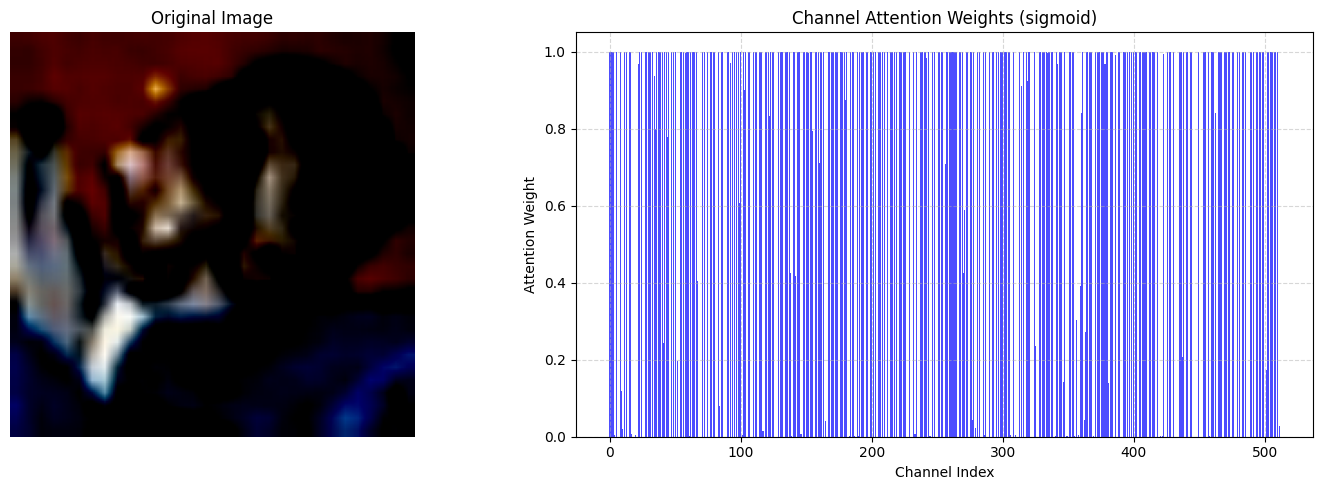


Training with Spatial: Sigmoid + Channel: SOFTMAX


Epoch 1: 100%|██████████| 782/782 [01:28<00:00,  8.80it/s]


Epoch 1: Train Loss: 1.6820, Train Acc: 35.40% | Test Loss: 1.4791, Test Acc: 40.72%


Epoch 2: 100%|██████████| 782/782 [01:28<00:00,  8.83it/s]


Epoch 2: Train Loss: 1.3786, Train Acc: 42.73% | Test Loss: 1.3107, Test Acc: 43.60%


Epoch 3: 100%|██████████| 782/782 [01:28<00:00,  8.79it/s]


Epoch 3: Train Loss: 1.1287, Train Acc: 55.00% | Test Loss: 0.9509, Test Acc: 61.61%


Epoch 4: 100%|██████████| 782/782 [01:28<00:00,  8.83it/s]


Epoch 4: Train Loss: 0.8198, Train Acc: 70.65% | Test Loss: 0.7176, Test Acc: 76.82%


Epoch 5: 100%|██████████| 782/782 [01:28<00:00,  8.79it/s]


Epoch 5: Train Loss: 0.6225, Train Acc: 79.99% | Test Loss: 0.6112, Test Acc: 80.62%


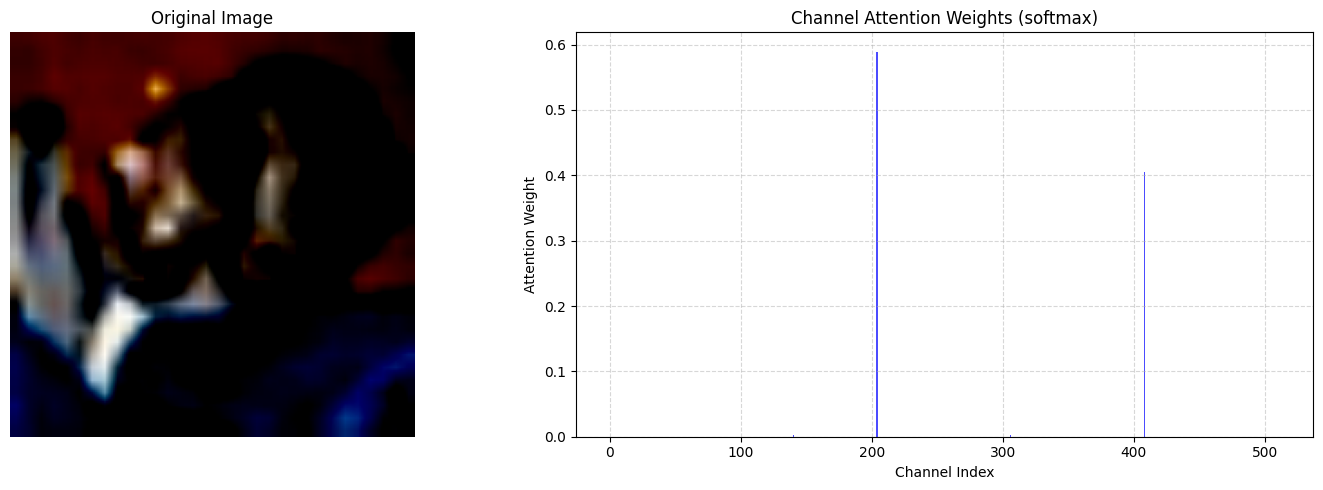


Training with Spatial: Sigmoid + Channel: SPARSEMAX


Epoch 1: 100%|██████████| 782/782 [01:31<00:00,  8.52it/s]


Epoch 1: Train Loss: 1.9532, Train Acc: 24.18% | Test Loss: 1.8485, Test Acc: 23.99%


Epoch 2: 100%|██████████| 782/782 [01:31<00:00,  8.58it/s]


Epoch 2: Train Loss: 1.7848, Train Acc: 27.29% | Test Loss: 1.9594, Test Acc: 25.04%


Epoch 3: 100%|██████████| 782/782 [01:31<00:00,  8.55it/s]


Epoch 3: Train Loss: 1.7561, Train Acc: 29.12% | Test Loss: 1.9360, Test Acc: 26.01%


Epoch 4: 100%|██████████| 782/782 [01:31<00:00,  8.53it/s]


Epoch 4: Train Loss: 1.7350, Train Acc: 30.80% | Test Loss: 1.7536, Test Acc: 29.61%


Epoch 5: 100%|██████████| 782/782 [01:31<00:00,  8.55it/s]


Epoch 5: Train Loss: 1.6767, Train Acc: 32.33% | Test Loss: 1.8016, Test Acc: 28.18%


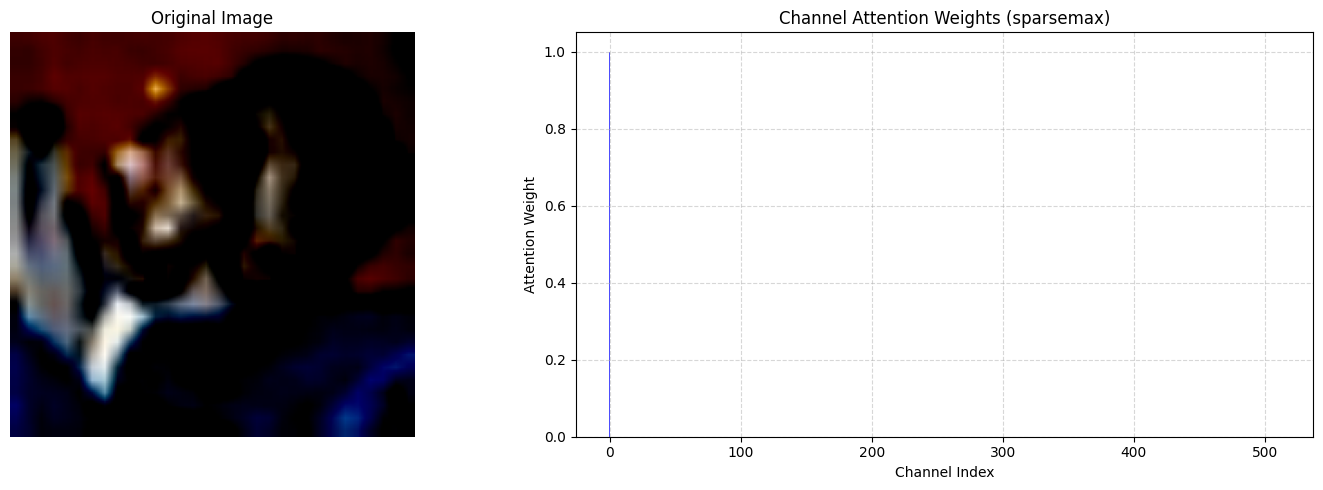


Training with Spatial: Sigmoid + Channel: SCALED_TANH


Epoch 1: 100%|██████████| 782/782 [01:28<00:00,  8.79it/s]


Epoch 1: Train Loss: 0.6130, Train Acc: 78.94% | Test Loss: 0.4361, Test Acc: 85.00%


Epoch 2: 100%|██████████| 782/782 [01:29<00:00,  8.77it/s]


Epoch 2: Train Loss: 0.3318, Train Acc: 88.67% | Test Loss: 0.3718, Test Acc: 87.37%


Epoch 3: 100%|██████████| 782/782 [01:28<00:00,  8.80it/s]


Epoch 3: Train Loss: 0.2310, Train Acc: 91.99% | Test Loss: 0.4042, Test Acc: 86.93%


Epoch 4: 100%|██████████| 782/782 [01:29<00:00,  8.78it/s]


Epoch 4: Train Loss: 0.1621, Train Acc: 94.34% | Test Loss: 0.3709, Test Acc: 88.11%


Epoch 5: 100%|██████████| 782/782 [01:29<00:00,  8.78it/s]


Epoch 5: Train Loss: 0.1172, Train Acc: 95.99% | Test Loss: 0.3530, Test Acc: 89.46%


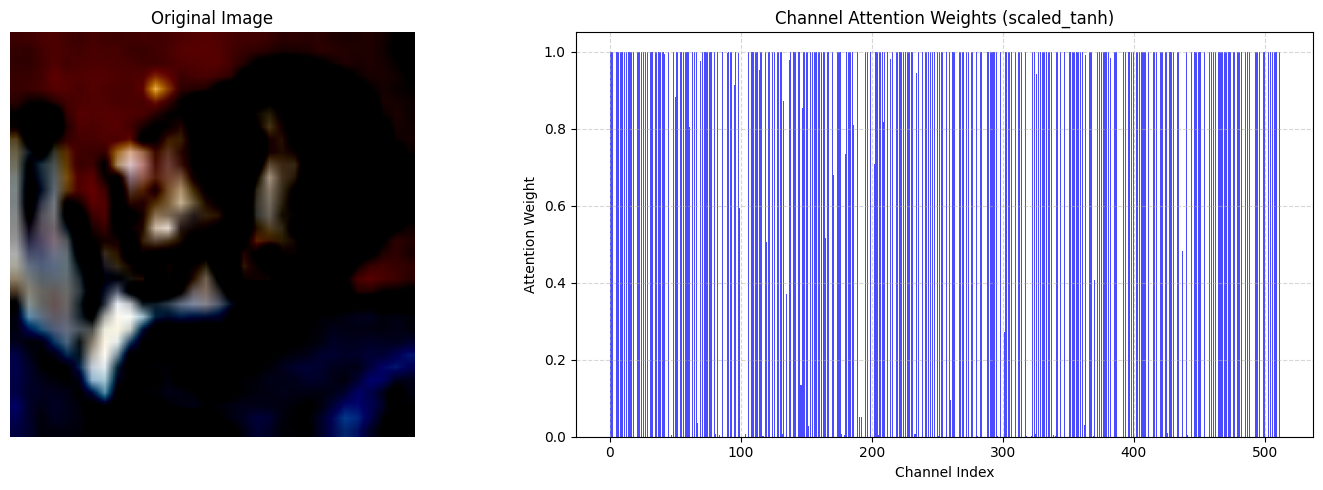


Training with Spatial: Sigmoid + Channel: PARAMETRIC_SIGMOID


Epoch 1: 100%|██████████| 782/782 [01:29<00:00,  8.75it/s]


Epoch 1: Train Loss: 0.6326, Train Acc: 78.25% | Test Loss: 0.5248, Test Acc: 81.97%


Epoch 2: 100%|██████████| 782/782 [01:29<00:00,  8.75it/s]


Epoch 2: Train Loss: 0.3390, Train Acc: 88.39% | Test Loss: 0.3432, Test Acc: 88.54%


Epoch 3: 100%|██████████| 782/782 [01:29<00:00,  8.75it/s]


Epoch 3: Train Loss: 0.2306, Train Acc: 92.12% | Test Loss: 0.3235, Test Acc: 89.67%


Epoch 4: 100%|██████████| 782/782 [01:29<00:00,  8.78it/s]


Epoch 4: Train Loss: 0.1618, Train Acc: 94.45% | Test Loss: 0.3411, Test Acc: 89.93%


Epoch 5: 100%|██████████| 782/782 [01:29<00:00,  8.76it/s]


Epoch 5: Train Loss: 0.1214, Train Acc: 95.95% | Test Loss: 0.3186, Test Acc: 90.40%


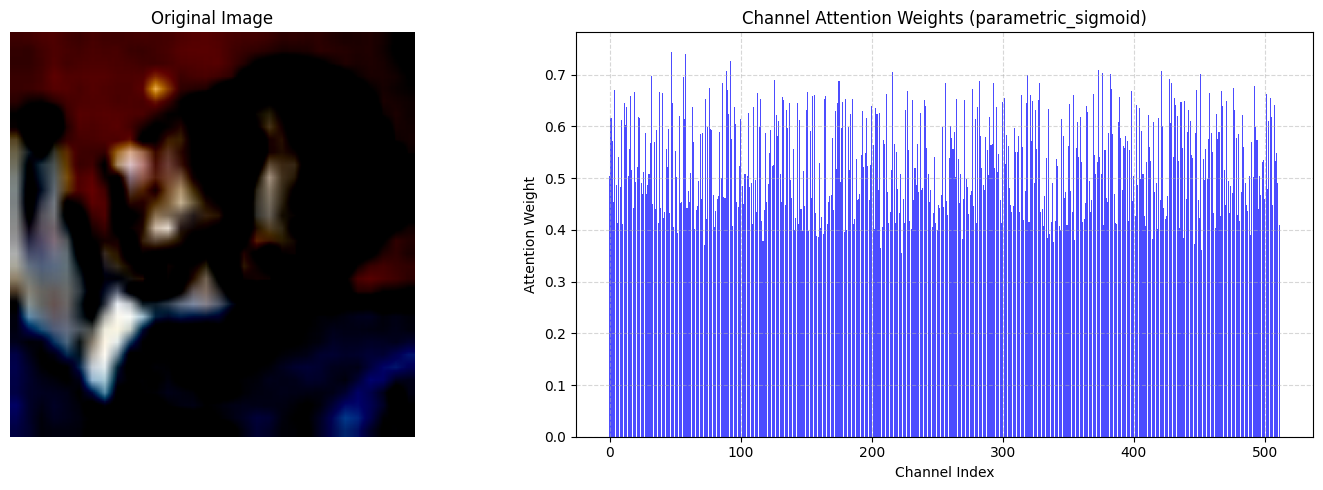


Training with Spatial: Sigmoid + Channel: SWISH


Epoch 1: 100%|██████████| 782/782 [01:29<00:00,  8.72it/s]


Epoch 1: Train Loss: 0.6008, Train Acc: 79.75% | Test Loss: 0.4883, Test Acc: 84.14%


Epoch 2: 100%|██████████| 782/782 [01:29<00:00,  8.70it/s]


Epoch 2: Train Loss: 0.3441, Train Acc: 88.47% | Test Loss: 0.4096, Test Acc: 86.68%


Epoch 3: 100%|██████████| 782/782 [01:29<00:00,  8.71it/s]


Epoch 3: Train Loss: 0.2389, Train Acc: 91.88% | Test Loss: 0.4144, Test Acc: 86.30%


Epoch 4: 100%|██████████| 782/782 [01:29<00:00,  8.69it/s]


Epoch 4: Train Loss: 0.1763, Train Acc: 93.88% | Test Loss: 0.3674, Test Acc: 88.39%


Epoch 5: 100%|██████████| 782/782 [01:29<00:00,  8.71it/s]


Epoch 5: Train Loss: 0.1300, Train Acc: 95.53% | Test Loss: 0.4310, Test Acc: 88.73%


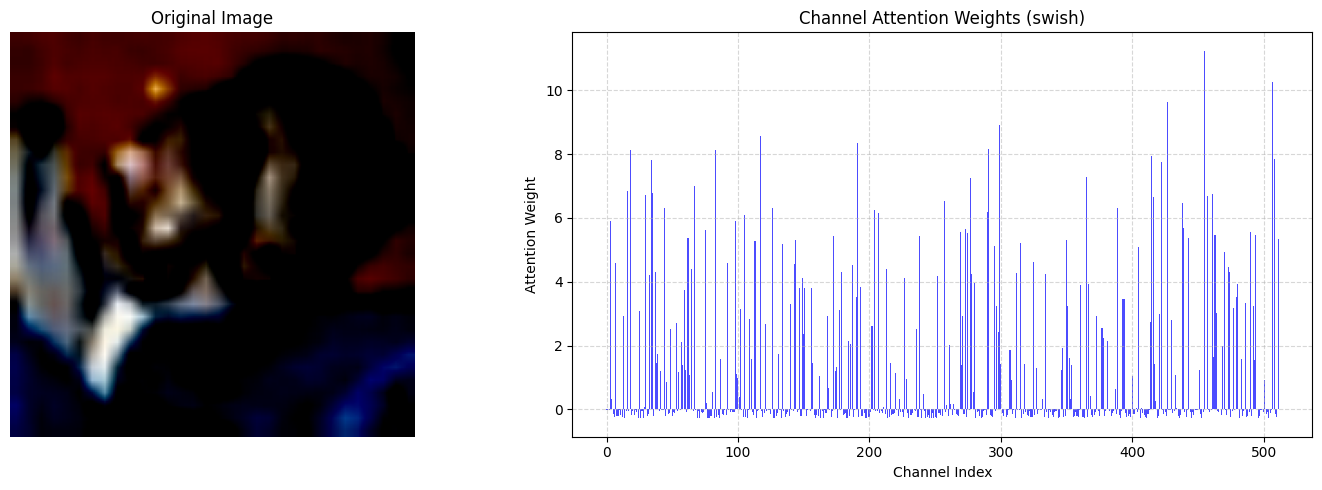

In [ ]:
# Define all channel activation types to test
channel_activation_types = ['sigmoid', 'softmax', 'sparsemax', 'scaled_tanh','parametric_sigmoid','swish']

# Experiment loop
for channel_act in channel_activation_types:
    print(f"\n{'='*40}")
    print(f"Training with Spatial: Sigmoid + Channel: {channel_act.upper()}")
    print(f"{'='*40}")

    # Initialise fresh model for each configuration
    model = ResNet18_CBAM(
        attention_position="late",
        channel_activation=channel_act
    ).to(device)

    # Train for 5 epochs
    trained_model = train_model(
        model,
        train_loader,
        test_loader,
        num_epochs=5,
        lr=0.001
    )

    # Visualise attention
    visualize_attention(trained_model, test_loader, channel_act)

    # Clean up to save memory
    del model
    torch.cuda.empty_cache()